# To Do 

1. Fix code

    1.1 Use true parameters except for delta and see if that works
    
    1.2 Upload problem to PyMC3 discussion board / there is this one guy who answers *all* questions 

# Bayesian estimation

## Import Modules

In [1]:
import respy as rp
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt

## Simulate (robinson) data 

In [18]:
theta_0, options_0, data = rp.get_example_model("robinson", with_data=True)

In [19]:
theta_0

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

## Create Log-Likelihood which is only dependent on parameters (theta)

In [20]:
likelihood = rp.get_crit_func(theta_0, options_0, data)
likelihood(theta_0)

9.033443270309705

## Create wrapper class around custom Log-Likelihood

In [45]:
class respyLogLik(tt.Op):
    """
    Class wrapper around loglikehood s.t. PyMC3 
    can use the custom likelihood function from respy.
    Inherits from tt.Op. 
    """
    itypes = [tt.dvector]
    otypes = [tt.dscalar] 
    
    def __init__(self, loglik, theta_0):   #:param_idx, theta_0):
        """
        Initialize the Op with <loglik> function.
        
        Parameters
        ----------
        loglik:
            The log-likelihood function 
        """
        
        self.likelihood = loglik
        #self.index = param_idx
        self.theta_0 = theta_0
    
    def perform(self, node, inputs, outputs):
        """Method which is used when calling the Op"""

        # modify input for respy log-likelihood
        #theta = pd.Series(data=inputs[0].reshape(-1),
        #                 index=self.index)
        
        theta_0.loc['delta', 'delta'] = inputs[0][0]
        theta_0.loc['wage_fishing', 'exp_fishing'] = inputs[0][1]
        
        # compute log-likelihood value        
        logl = self.likelihood(theta_0)
        print("delta=", inputs[0][0], "exp_f=", inputs[0][1], "logl=", logl) # debugging
        
        # store output
        outputs[0][0] = np.array(logl)

## Set values for MCMC simulation

In [46]:
ndraws = 10  #int(5e3)
nburn = 3  #int(1e1)

## Set Log-Likelihood

In [47]:
loglik = respyLogLik(likelihood, theta_0)   #theta_0.index

## Define priors and sample from Log-Likelihood using ```pyMC3```

In [55]:
with pm.Model():
    
    ## Priors; we choose very large variances to make them uninformative 
    
    # discount factor is uniform on [0, 1]
    delta = pm.Uniform('delta', lower=0.6, upper=1)
    
    # experience accumulation parameter is HalfNormal with very large variance
    #exp_fishing = pm.HalfNormal('exp_fishing', sigma=0.5)
    exp_fishing = pm.Uniform('exp_fishing', lower=0.07, upper=0.071)
    
    # constant priors are normal with very large variance and centered around zero
    #nonpec_fishing = pm.Normal('nonpec_fishing', mu=0., sigma=1e3)
    #nonpec_hammock = pm.Normal('nonpec_hammock', mu=0., sigma=1e3)
    
    # standard deviations are InverseGamma with very large variance
    #sd_fishing = pm.InverseGamma('sd_fishing', alpha=0.01, beta=0.01)
    #sd_hammock = pm.InverseGamma('sd_hammock', alpha=0.01, beta=0.01)
    
    # correlation is uniform on [-1, 1]
    #corr_hammock_fishing = pm.Uniform('corr_hammock_fishing', lower=-1., upper=1.)
    
    ## Parameter vector (convert parameters to tensor vector)
    theta = tt.as_tensor_variable([
        delta,
        exp_fishing
    ])
    """,
        exp_fishing,
        nonpec_fishing,
        nonpec_hammock,
        sd_fishing,
        sd_hammock,
        corr_hammock_fishing
    ))
    """
    
    ## Density Distribution 
    pm.DensityDist('likelihood', lambda v: loglik(v), observed={'v': theta})
    
    
    ## Trace  
    trace = pm.sample(ndraws, tune=nburn)  #, discard_tuned_samples=True)

delta= 0.8 exp_f= 0.07050000000000001 logl= -26.402211035515528
delta= 0.8 exp_f= 0.07050000000000001 logl= -26.402211035515528


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.


delta= 0.8 exp_f= 0.07050000000000001 logl= -26.402211035515528


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [exp_fishing]
>Slice: [delta]
Sampling 2 chains:   0%|          | 0/26 [00:00<?, ?draws/s]

delta= 0.8 exp_f= 0.07050000000000001 logl= -26.402211035515528
delta= 0.8 exp_f= 0.07050000000000001 logl= -26.402211035515528
delta= 0.8 exp_f= 0.07039842153485985 logl= -26.802046221667457
delta= 0.8 exp_f= 0.07039842153485985 logl= -26.802046221667457
delta= 0.8 exp_f= 0.07019591148624689 logl= -27.604645827090856
delta= 0.8 exp_f= 0.07019591148624689 logl= -27.604645827090856
delta= 0.8 exp_f= 0.07073105857863 logl= -25.499547305800412
delta= 0.8 exp_f= 0.07073105857863 logl= -25.499547305800412
delta= 0.8 exp_f= 0.07088079707797788 logl= -24.91964181913761
delta= 0.8 exp_f= 0.07088079707797788 logl= -24.91964181913761
delta= 0.8 exp_f= 0.07095257412682243 logl= -24.643078102664155
delta= 0.8 exp_f= 0.07095257412682243 logl= -24.643078102664155
delta= 0.8 exp_f= 0.0709820137900379 logl= -24.5299092303241
delta= 0.8 exp_f= 0.0709820137900379 logl= -24.5299092303241
delta= 0.8 exp_f= 0.07099330714907572 logl= -24.486537378455225
delta= 0.8 exp_f= 0.07099330714907572 logl= -24.486537

Sampling 2 chains:   4%|▍         | 1/26 [00:08<03:24,  8.18s/draws]

delta= 0.9999999938202853 exp_f= 0.07094742139399124 logl= -0.799513346058265
delta= 0.9999999938202853 exp_f= 0.07094742139399124 logl= -0.799513346058265
delta= 0.9999999938202853 exp_f= 0.07094742139399124 logl= -0.799513346058265
delta= 0.9999999938202853 exp_f= 0.0705620224248096 logl= 1.0210525976633016
delta= 0.9999999938202853 exp_f= 0.0705620224248096 logl= 1.0210525976633016
delta= 0.9999999938202853 exp_f= 0.07000210218760734 logl= 3.565979991339728
delta= 0.9999999938202853 exp_f= 0.07000210218760734 logl= 3.565979991339728
delta= 0.9999999938202853 exp_f= 0.07000000345833875 logl= 3.5751867851256978
delta= 0.9999999938202853 exp_f= 0.07000000345833875 logl= 3.5751867851256978
delta= 0.9999999938202853 exp_f= 0.07099990890176841 logl= -1.0502004129047617
delta= 0.9999999938202853 exp_f= 0.07099990890176841 logl= -1.0502004129047617
delta= 0.9999999938202853 exp_f= 0.07089177083451095 logl= -0.5343924536584355
delta= 0.9999999938202853 exp_f= 0.07089177083451095 logl= -0.534

Sampling 2 chains:  12%|█▏        | 3/26 [00:10<02:19,  6.07s/draws]

delta= 0.9999536079188229 exp_f= 0.07089177083451095 logl= -0.5185545866557575
delta= 0.9999536079188229 exp_f= 0.07089177083451095 logl= -0.5185545866557575
delta= 0.9999536079188229 exp_f= 0.07089177083451095 logl= -0.5185545866557575
delta= 0.9999536079188229 exp_f= 0.07002367239184051 logl= 3.485846541034637
delta= 0.9999536079188229 exp_f= 0.07002367239184051 logl= 3.485846541034637
delta= 0.9999536079188229 exp_f= 0.07000000001743804 logl= 3.589820697645221
delta= 0.9999536079188229 exp_f= 0.07000000001743804 logl= 3.589820697645221
delta= 0.9999536079188229 exp_f= 0.0709999999127145 logl= -1.03471938204341
delta= 0.9999536079188229 exp_f= 0.0709999999127145 logl= -1.03471938204341
delta= 0.9999536079188229 exp_f= 0.0709935316274139 logl= -1.0037979331566804
delta= 0.9999536079188229 exp_f= 0.0709935316274139 logl= -1.0037979331566804
delta= 0.9999536079188229 exp_f= 0.07007614959485786 logl= 3.2540288111592206
delta= 0.9999536079188229 exp_f= 0.07007614959485786 logl= 3.25402881

Sampling 2 chains:  19%|█▉        | 5/26 [00:12<01:37,  4.62s/draws]

delta= 0.9999727709893405 exp_f= 0.07007614959485786 logl= 3.2479231380663074
delta= 0.9999727709893405 exp_f= 0.07007614959485786 logl= 3.2479231380663074
delta= 0.9999727709893405 exp_f= 0.07007614959485786 logl= 3.2479231380663074
delta= 0.9999727709893405 exp_f= 0.07000007287984973 logl= 3.583462824790624
delta= 0.9999727709893405 exp_f= 0.07000007287984973 logl= 3.583462824790624
delta= 0.9999727709893405 exp_f= 0.0709999995284386 logl= -1.0412926231704882
delta= 0.9999727709893405 exp_f= 0.0709999995284386 logl= -1.0412926231704882
delta= 0.9999727709893405 exp_f= 0.0709987000023892 logl= -1.0350791782280806
delta= 0.9999727709893405 exp_f= 0.0709987000023892 logl= -1.0350791782280806
delta= 0.9999727709893405 exp_f= 0.0707902516003893 logl= -0.04339197804208152
delta= 0.9999727709893405 exp_f= 0.0707902516003893 logl= -0.04339197804208152
delta= 0.9999727709893405 exp_f= 0.07009599596568594 logl= 3.1598030065568845
delta= 0.9999727709893405 exp_f= 0.07009599596568594 logl= 3.159

Sampling 2 chains:  27%|██▋       | 7/26 [00:15<01:08,  3.61s/draws]

delta= 0.9999829514951749 exp_f= 0.07009599596568594 logl= 3.1565507406200384
delta= 0.9999829514951749 exp_f= 0.07009599596568594 logl= 3.1565507406200384
delta= 0.9999829514951749 exp_f= 0.07009599596568594 logl= 3.1565507406200384
delta= 0.9999829514951749 exp_f= 0.07000017799076581 logl= 3.5797933516028726
delta= 0.9999829514951749 exp_f= 0.07000017799076581 logl= 3.5797933516028726
delta= 0.9999829514951749 exp_f= 0.07099999827112725 logl= -1.0447798240268837
delta= 0.9999829514951749 exp_f= 0.07099999827112725 logl= -1.0447798240268837
delta= 0.9999829514951749 exp_f= 0.07099768449265106 logl= -1.0337168187045813
delta= 0.9999829514951749 exp_f= 0.07099768449265106 logl= -1.0337168187045813
delta= 0.9999829514951749 exp_f= 0.07077416674730634 logl= 0.02924246495939758
delta= 0.9999829514951749 exp_f= 0.07077416674730634 logl= 0.02924246495939758
delta= 0.9999829514951749 exp_f= 0.07011792235065 logl= 3.058928173645567
delta= 0.9999829514951749 exp_f= 0.07011792235065 logl= 3.0589

Sampling 2 chains:  35%|███▍      | 9/26 [00:17<00:49,  2.90s/draws]

delta= 0.9999888611926495 exp_f= 0.07011792235065 logl= 3.0570350618585596
delta= 0.9999888611926495 exp_f= 0.07011792235065 logl= 3.0570350618585596
delta= 0.9999888611926495 exp_f= 0.07011792235065 logl= 3.0570350618585596
delta= 0.9999888611926495 exp_f= 0.07000022407022607 logl= 3.577728528287256
delta= 0.9999888611926495 exp_f= 0.07000022407022607 logl= 3.577728528287256
delta= 0.9999888611926495 exp_f= 0.07099999862672825 logl= -1.0468093555658402
delta= 0.9999888611926495 exp_f= 0.07099999862672825 logl= -1.0468093555658402
delta= 0.9999888611926495 exp_f= 0.07099815987911504 logl= -1.03801738637385
delta= 0.9999888611926495 exp_f= 0.07099815987911504 logl= -1.03801738637385
delta= 0.9999888611926495 exp_f= 0.07081187875057833 logl= -0.15127328919664682
delta= 0.9999888611926495 exp_f= 0.07081187875057833 logl= -0.15127328919664682
delta= 0.9999888611926495 exp_f= 0.0701440588412361 logl= 2.940316980617471
delta= 0.9999888611926495 exp_f= 0.0701440588412361 logl= 2.9403169806174

Sampling 2 chains:  42%|████▏     | 11/26 [00:20<00:35,  2.37s/draws]

delta= 0.9999927223885602 exp_f= 0.0701440588412361 logl= 2.9390761607853113
delta= 0.9999927223885602 exp_f= 0.0701440588412361 logl= 2.9390761607853113
delta= 0.9999927223885602 exp_f= 0.0701440588412361 logl= 2.9390761607853113
delta= 0.9999927223885602 exp_f= 0.07000028207568489 logl= 3.576256995975268
delta= 0.9999927223885602 exp_f= 0.07000028207568489 logl= 3.576256995975268
delta= 0.9999927223885602 exp_f= 0.07099999890918798 logl= -1.0481356424967583
delta= 0.9999927223885602 exp_f= 0.07099999890918798 logl= -1.0481356424967583
delta= 0.9999927223885602 exp_f= 0.07099853780914922 logl= -1.0411492507156321
delta= 0.9999927223885602 exp_f= 0.07099853780914922 logl= -1.0411492507156321
delta= 0.9999927223885602 exp_f= 0.07084455767123704 logl= -0.3075576248319152
delta= 0.9999927223885602 exp_f= 0.07084455767123704 logl= -0.3075576248319152
delta= 0.9999927223885602 exp_f= 0.07017484002422839 logl= 2.8011360667864746
delta= 0.9999927223885602 exp_f= 0.07017484002422839 logl= 2.80

Sampling 2 chains:  50%|█████     | 13/26 [00:22<00:26,  2.03s/draws]

delta= 0.9999952451416588 exp_f= 0.07017484002422839 logl= 2.8003223703134146
delta= 0.9999952451416588 exp_f= 0.07017484002422839 logl= 2.8003223703134146
delta= 0.9999952451416588 exp_f= 0.07017484002422839 logl= 2.8003223703134146
delta= 0.9999952451416588 exp_f= 0.07000035509178695 logl= 3.5751414826565
delta= 0.9999952451416588 exp_f= 0.07000035509178695 logl= 3.5751414826565
delta= 0.9999952451416588 exp_f= 0.07099999913355039 logl= -1.0490023850591905
delta= 0.9999952451416588 exp_f= 0.07099999913355039 logl= -1.0490023850591905
delta= 0.9999952451416588 exp_f= 0.07099883820902433 logl= -1.0434512302512482
delta= 0.9999952451416588 exp_f= 0.07099883820902433 logl= -1.0434512302512482
delta= 0.9999952451416588 exp_f= 0.07087245169875742 logl= -0.44090341009792405
delta= 0.9999952451416588 exp_f= 0.07087245169875742 logl= -0.44090341009792405
delta= 0.9999952451416588 exp_f= 0.07021058015466598 logl= 2.63950844117628
delta= 0.9999952451416588 exp_f= 0.07021058015466598 logl= 2.639

Sampling 2 chains:  58%|█████▊    | 15/26 [00:25<00:19,  1.78s/draws]

delta= 0.9999968933999015 exp_f= 0.07021058015466598 logl= 2.638974515419992


Sampling 2 chains:  62%|██████▏   | 16/26 [00:25<00:13,  1.30s/draws]

delta= 0.9999968933999015 exp_f= 0.07021058015466598 logl= 2.638974515419992
delta= 0.9999968933999015 exp_f= 0.07000044699986613 logl= 3.574218747173483
delta= 0.9999968933999015 exp_f= 0.07021058015466598 logl= 2.638974515419992
delta= 0.9999968933999015 exp_f= 0.0709999993117651 logl= -1.049568832234817
delta= 0.9999968933999015 exp_f= 0.07000044699986613 logl= 3.574218747173483
delta= 0.9999968933999015 exp_f= 0.0709990769502816 logl= -1.045158360048109
delta= 0.9999968933999015 exp_f= 0.0709999993117651 logl= -1.049568832234817
delta= 0.9999968933999015 exp_f= 0.07089595680895047 logl= -0.5532508694676933
delta= 0.9999968933999015 exp_f= 0.0709990769502816 logl= -1.045158360048109
delta= 0.9999968933999015 exp_f= 0.07025140028018027 logl= 2.4544363832482206
delta= 0.9999968933999015 exp_f= 0.07089595680895047 logl= -0.5532508694676933
delta= 0.9999968933999015 exp_f= 0.07025140028018027 logl= 2.4544363832482206
delta= 0.9999968933999015 exp_f= 0.07025140028018027 logl= 2.454436383

Sampling 2 chains:  65%|██████▌   | 17/26 [00:27<00:14,  1.58s/draws]

delta= 0.9999979702969692 exp_f= 0.07025140028018027 logl= 2.454085800413979
delta= 0.9999979702969692 exp_f= 0.07025140028018027 logl= 2.454085800413979


Sampling 2 chains:  69%|██████▉   | 18/26 [00:27<00:09,  1.16s/draws]

delta= 0.9999979702969692 exp_f= 0.07025140028018027 logl= 2.454085800413979
delta= 0.9999979702969692 exp_f= 0.07000056268303839 logl= 3.5733718231683054
delta= 0.9999979702969692 exp_f= 0.07099999945332393 logl= -1.0499390447897452
delta= 0.9999979702969692 exp_f= 0.07000056268303839 logl= 3.5733718231683054
delta= 0.9999979702969692 exp_f= 0.0709992666676245 logl= -1.046435043692412
delta= 0.9999979702969692 exp_f= 0.07099999945332393 logl= -1.0499390447897452
delta= 0.9999979702969692 exp_f= 0.0709155495895103 logl= -0.64689664757668
delta= 0.9999979702969692 exp_f= 0.0709992666676245 logl= -1.046435043692412
delta= 0.9999979702969692 exp_f= 0.07029715466882512 logl= 2.246128844815502
delta= 0.9999979702969692 exp_f= 0.0709155495895103 logl= -0.64689664757668
delta= 0.9999979702969692 exp_f= 0.07029715466882512 logl= 2.246128844815502
delta= 0.9999979702969692 exp_f= 0.07029715466882512 logl= 2.246128844815502
delta= 0.8373524479788151 exp_f= 0.07029715466882512 logl= -15.470533714

Sampling 2 chains:  73%|███████▎  | 19/26 [00:29<00:10,  1.49s/draws]

delta= 0.9999999967020745 exp_f= 0.07029715466882512 logl= 2.245465441241907
delta= 0.9999986738909361 exp_f= 0.07029715466882512 logl= 2.245898503878859


Sampling 2 chains:  77%|███████▋  | 20/26 [00:30<00:06,  1.11s/draws]

delta= 0.9999986738909361 exp_f= 0.07029715466882512 logl= 2.245898503878859
delta= 0.9999986738909361 exp_f= 0.07000070828369932 logl= 3.572511331429747
delta= 0.9999986738909361 exp_f= 0.07029715466882512 logl= 2.245898503878859
delta= 0.9999986738909361 exp_f= 0.07000070828369932 logl= 3.572511331429747
delta= 0.9999986738909361 exp_f= 0.07099999956576641 logl= -1.0501810203752475
delta= 0.9999986738909361 exp_f= 0.07099941741449671 logl= -1.0473973005132253
delta= 0.9999986738909361 exp_f= 0.07099999956576641 logl= -1.0501810203752475
delta= 0.9999986738909361 exp_f= 0.07093173389995229 logl= -0.7242546792070682
delta= 0.9999986738909361 exp_f= 0.07099941741449671 logl= -1.0473973005132253
delta= 0.9999986738909361 exp_f= 0.07034737220053928 logl= 2.0163112093550946
delta= 0.9999986738909361 exp_f= 0.07093173389995229 logl= -0.7242546792070682
delta= 0.9999986738909361 exp_f= 0.07034737220053928 logl= 2.0163112093550946
delta= 0.9999986738909361 exp_f= 0.07034737220053928 logl= 2.0

Sampling 2 chains:  81%|████████  | 21/26 [00:32<00:07,  1.48s/draws]

delta= 0.9999999964720862 exp_f= 0.07034737220053928 logl= 2.0158756235231112
delta= 0.9855465548661665 exp_f= 0.07034737220053928 logl= 6.29165979737073
delta= 0.9855465548661665 exp_f= 0.07034737220053928 logl= 6.29165979737073


Sampling 2 chains:  85%|████████▍ | 22/26 [00:32<00:04,  1.15s/draws]

delta= 0.9855465548661665 exp_f= 0.07000089152658584 logl= 7.266184425055852
delta= 0.9855465548661665 exp_f= 0.07034737220053928 logl= 6.29165979737073
delta= 0.9855465548661665 exp_f= 0.07099999965508129 logl= 3.737850140503392
delta= 0.9855465548661665 exp_f= 0.07099953718756319 logl= 3.7398662480667935
delta= 0.9855465548661665 exp_f= 0.07000089152658584 logl= 7.266184425055852
delta= 0.9855465548661665 exp_f= 0.07094500291787738 logl= 3.97622333749896
delta= 0.9855465548661665 exp_f= 0.07099999965508129 logl= 3.737850140503392
delta= 0.9855465548661665 exp_f= 0.07040123156139999 logl= 6.1111412950240505
delta= 0.9855465548661665 exp_f= 0.07099953718756319 logl= 3.7398662480667935
delta= 0.9855465548661665 exp_f= 0.07094500291787738 logl= 3.97622333749896
delta= 0.9855465548661665 exp_f= 0.07040123156139999 logl= 6.1111412950240505
delta= 0.9855465548661665 exp_f= 0.07040123156139999 logl= 6.1111412950240505
delta= 0.6000789951740265 exp_f= 0.07040123156139999 logl= -65.11188817432

Sampling 2 chains:  88%|████████▊ | 23/26 [00:35<00:04,  1.60s/draws]

delta= 0.7687230611911483 exp_f= 0.07040123156139999 logl= -35.44841766297708
delta= 0.9662971345498759 exp_f= 0.07040123156139999 logl= 8.493658434348305
delta= 0.9662971345498759 exp_f= 0.07040123156139999 logl= 8.493658434348305


Sampling 2 chains:  92%|█████████▏| 24/26 [00:35<00:02,  1.21s/draws]

delta= 0.9662971345498759 exp_f= 0.0700011221237319 logl= 8.736239520881142
delta= 0.9662971345498759 exp_f= 0.07040123156139999 logl= 8.493658434348305
delta= 0.9662971345498759 exp_f= 0.0700011221237319 logl= 8.736239520881142
delta= 0.9662971345498759 exp_f= 0.07099999972602553 logl= 7.88027330060574
delta= 0.9662971345498759 exp_f= 0.07099999972602553 logl= 7.88027330060574
delta= 0.9662971345498759 exp_f= 0.0709996323456846 logl= 7.880800486167647
delta= 0.9662971345498759 exp_f= 0.07095581511817473 logl= 7.941842288794238
delta= 0.9662971345498759 exp_f= 0.0709996323456846 logl= 7.880800486167647
delta= 0.9662971345498759 exp_f= 0.07045758659781946 logl= 8.45123058256823
delta= 0.9662971345498759 exp_f= 0.07095581511817473 logl= 7.941842288794238
delta= 0.9662971345498759 exp_f= 0.07045758659781946 logl= 8.45123058256823
delta= 0.9662971345498759 exp_f= 0.07045758659781946 logl= 8.45123058256823
delta= 0.9662971345498759 exp_f= 0.07045758659781946 logl= 8.45123058256823
delta= 0.

Sampling 2 chains:  96%|█████████▌| 25/26 [00:38<00:01,  1.69s/draws]

delta= 0.6916524150930027 exp_f= 0.07045758659781946 logl= -52.37315297919637
delta= 0.9263108463097703 exp_f= 0.07045758659781946 logl= 8.65082037327663


Sampling 2 chains: 100%|██████████| 26/26 [00:38<00:00,  1.49s/draws]
/home/tm/anaconda3/envs/respy/lib/python3.7/site-packages/pymc3/sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


delta= 0.9999829514951749 exp_f= 0.07009599596568594 logl= 3.1565507406200384
delta= 0.9999888611926495 exp_f= 0.07011792235065 logl= 3.0570350618585596
delta= 0.9999927223885602 exp_f= 0.0701440588412361 logl= 2.9390761607853113
delta= 0.9999952451416588 exp_f= 0.07017484002422839 logl= 2.8003223703134146
delta= 0.9999968933999015 exp_f= 0.07021058015466598 logl= 2.638974515419992
delta= 0.9999979702969692 exp_f= 0.07025140028018027 logl= 2.454085800413979
delta= 0.9999986738909361 exp_f= 0.07029715466882512 logl= 2.245898503878859
delta= 0.9855465548661665 exp_f= 0.07034737220053928 logl= 6.29165979737073
delta= 0.9662971345498759 exp_f= 0.07040123156139999 logl= 8.493658434348305
delta= 0.9263108463097703 exp_f= 0.07045758659781946 logl= 8.65082037327663
delta= 0.9999829514951749 exp_f= 0.07009599596568594 logl= 3.1565507406200384
delta= 0.9999888611926495 exp_f= 0.07011792235065 logl= 3.0570350618585596
delta= 0.9999927223885602 exp_f= 0.0701440588412361 logl= 2.9390761607853113
de

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f427024de48>,
      dtype=object)

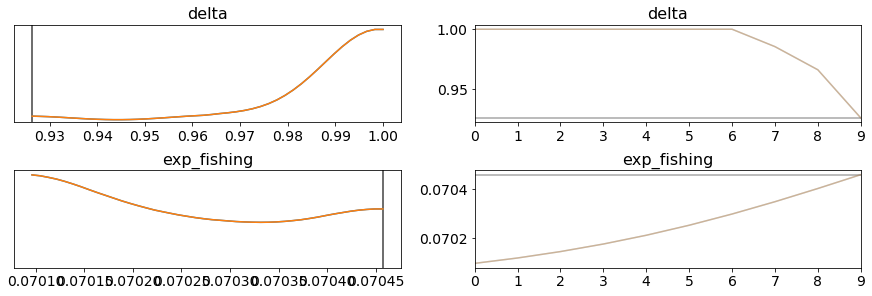

In [56]:
pm.traceplot(trace, lines=[('delta', {}, theta_0.loc['delta', 'delta']),
                          ('exp_fishing', {}, theta_0.loc['wage_fishing', 'exp_fishing'])])